<a href="https://colab.research.google.com/github/anasshamoon12002/data-mining-2023-24/blob/main/Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Mining Project, a.y. 2023-2024
## Salvatore Correnti, Jonathan Ato Markin, Anas Shamoon
## Classification Notebook

# Preliminary
These cells are for running the notebook with `Google Colab` using a `Google Drive` storage for the project repository.They can be skipped if data is available locally.

In [1]:
from google.colab import drive

In [2]:
drive.mount('/content/drive')
%cd "drive/MyDrive/Colab Notebooks/data-mining-2023-24"

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/data-mining-2023-24


In [3]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score, KFold, StratifiedKFold, cross_validate
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, make_scorer, balanced_accuracy_score, classification_report
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import imblearn
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from joblib import Parallel, delayed

from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential

# Utils

In [4]:
def report_scores(test_label, test_pred, class_names=['Not Killed', 'Killed']):
    print(classification_report(test_label, test_pred, target_names=class_names))

# Dataset Preparation and Split

In [5]:
# Load the dataset
df_dataset = pd.read_csv('data/df_incidents_poverty_house_data_preparation_final.csv')

In [6]:
df_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92561 entries, 0 to 92560
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   state                         92561 non-null  object 
 1   city_or_county                92561 non-null  object 
 2   latitude                      92561 non-null  float64
 3   longitude                     92561 non-null  float64
 4   avg_age_participants          92561 non-null  float64
 5   datetime                      92561 non-null  object 
 6   males_ratio                   92561 non-null  float64
 7   state_congressional_district  92561 non-null  object 
 8   povertyPercentage             92561 non-null  float64
 9   killed_ratio                  92561 non-null  float64
 10  injured_ratio                 92561 non-null  float64
 11  unharmed_ratio                92561 non-null  float64
 12  candidate_winning_ratio       92561 non-null  float64
 13  m

In [7]:
df_dataset.drop(columns=['state', 'city_or_county', 'datetime', 'state_congressional_district', 'killed_in_month_ratio'], inplace=True)

In [8]:
df_dataset['isKilled'] = df_dataset['killed_ratio'].apply(lambda x: 1 if x > 0 else 0)

In [9]:
df_dataset.drop(columns=['killed_ratio'], inplace=True)

In [10]:
df_dataset.to_csv('data/unsplit_dataset.csv', index=False)

In [11]:
numpy_dataset = df_dataset.to_numpy()

In [12]:
X, y = numpy_dataset[:, 0:11], numpy_dataset[:, 11:]
print(X.shape, y.shape)

(92561, 11) (92561, 1)


In [13]:
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=18513, train_size=74048, random_state=0, shuffle=True, stratify=y)

In [14]:
df_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92561 entries, 0 to 92560
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   latitude                 92561 non-null  float64
 1   longitude                92561 non-null  float64
 2   avg_age_participants     92561 non-null  float64
 3   males_ratio              92561 non-null  float64
 4   povertyPercentage        92561 non-null  float64
 5   injured_ratio            92561 non-null  float64
 6   unharmed_ratio           92561 non-null  float64
 7   candidate_winning_ratio  92561 non-null  float64
 8   males_in_month_ratio     92561 non-null  float64
 9   injured_in_month_ratio   92561 non-null  float64
 10  unharmed_in_month_ratio  92561 non-null  float64
 11  isKilled                 92561 non-null  int64  
dtypes: float64(11), int64(1)
memory usage: 8.5 MB


In [15]:
input_columns = [
    'latitude', 'longitude', 'avg_age_participants', 'males_ratio', 'povertyPercentage', 'injured_ratio', 'unharmed_ratio',
    'candidate_winning_ratio', 'males_in_month_ratio', 'injured_in_month_ratio', 'unharmed_in_month_ratio'
]
output_column = ['isKilled']

In [16]:
X_dev_df, y_dev_df = pd.DataFrame(X_dev, columns=input_columns), pd.DataFrame(y_dev, columns=output_column)
X_test_df, y_test_df = pd.DataFrame(X_test, columns=input_columns), pd.DataFrame(y_test, columns=output_column)

In [17]:
X_dev_df.to_csv('data/dev_dataset_input.csv', index=False)
y_dev_df.to_csv('data/dev_dataset_output.csv', index=False)

X_test_df.to_csv('data/test_dataset_input.csv', index=False)
y_test_df.to_csv('data/test_dataset_output.csv', index=False)

In [18]:
# Undersampling for test set
from imblearn.under_sampling import RandomUnderSampler
undersample = RandomUnderSampler(sampling_strategy='majority', random_state=0)
X_test_u, y_test_u = undersample.fit_resample(X_test, y_test)
print(len(X_test_u), len(y_test_u[y_test_u == 0]), len(y_test_u[y_test_u == 1]))

8612 4306 4306


In [19]:
X_test_u_df, y_test_u_df = pd.DataFrame(X_test_u, columns=input_columns), pd.DataFrame(y_test_u, columns=output_column)

In [20]:
X_test_u_df.to_csv('data/test_dataset_undersampled_input.csv', index=False)
y_test_u_df.to_csv('data/test_dataset_undersampled_output.csv', index=False)

In [21]:
X_dev_orig, y_dev_orig, X_test_orig, y_test_orig = X_dev.copy(), y_dev.copy(), X_test_u.copy(), y_test_u.copy()

In [22]:
len(y_dev_orig[y_dev_orig == 0]), len(y_dev_orig[y_dev_orig == 1])

(56823, 17225)

In [23]:
len(y_dev_orig[y_dev_orig == 0])/len(y_dev_orig[y_dev_orig == 1])

3.298867924528302

Now visually show ratio of different classes examples in the dataset.

MultiIndex([(0,),
            (1,)],
           names=['isKilled'])


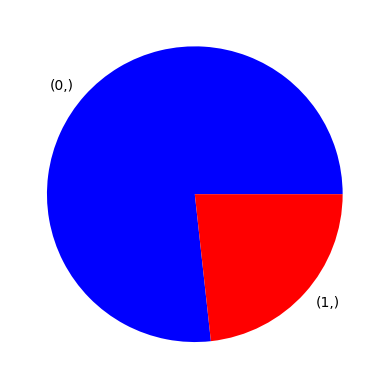

isKilled
0           56823
1           17225
dtype: int64


In [24]:
killed_value_count = y_dev_df.astype(int).value_counts()
print(killed_value_count.keys())
# Show pie plot
labels = ['not-killed', 'killed']
plt.pie(killed_value_count, labels=killed_value_count.index, colors=['blue', 'red'])
plt.show()
print(killed_value_count)

### Some utils

In [25]:
def before_classification(test_size=0.2, train_size=0.8, random_state=0, shuffle=True, normalize=True, balancing=None):
  X_dev, y_dev, X_test, y_test = X_dev_orig.copy(), y_dev_orig.copy(), X_test_orig.copy(), y_test_orig.copy()
  # Balancing: None, OverSampling, UnderSampling
  if balancing == 'oversampling':
    oversample = RandomOverSampler(sampling_strategy='minority', random_state=0)
    X_dev, y_dev = oversample.fit_resample(X_dev, y_dev)
  elif balancing == 'undersampling':
    undersample = RandomUnderSampler(sampling_strategy='majority', random_state=0)
    X_dev, y_dev = undersample.fit_resample(X_dev, y_dev)
  # Balancing is inherited by X_train and X_eval thanks to stratification
  global X_train, X_eval, y_train, y_eval
  X_train, X_eval, y_train, y_eval = train_test_split(
      X_dev, y_dev, test_size=test_size, train_size=train_size, random_state=random_state, shuffle=shuffle, stratify=y_dev
  )
  if normalize:
    scaler = StandardScaler()
    X_dev = scaler.fit_transform(X_dev)
    X_test = scaler.fit_transform(X_test)
    X_train = scaler.fit_transform(X_train)
    X_eval = scaler.fit_transform(X_eval)

In [26]:
def evaluate_on_dataset(model, X, y):
  predicted = model.predict(X)
  accuracy = tf.keras.metrics.Accuracy()
  accuracy.update_state(y, predicted)
  result = accuracy.result().numpy()
  print(f"Accuracy: {100*result:.4f}%")
  report_scores(y, predicted)

In [27]:
X_train, X_eval, y_train, y_eval = None, None, None, None

## Classification with Decision Trees

In [ ]:
# Function that finds the best decision tree doing hyperparameter search through CV.
# Retrains on the whole set at the end.
from sklearn.tree import DecisionTreeClassifier
def build_decision_tree(X, y, cv=5, print_res=True):
    params = [{
    'criterion': ['gini', 'entropy'],
    'max_depth': [5, 10, None],
    'max_features': ['sqrt', 'log2', None],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [2, 4]
    }]
    clf = GridSearchCV(DecisionTreeClassifier(), params, refit = True, cv=cv, scoring='accuracy', n_jobs=os.cpu_count(), verbose=10)
    clf.fit(X, y)
    if print_res:
        print("DT - Best parameters set found:")
        print(clf.best_params_)
        print("DT - Best accuraccy score found:")
        print(clf.best_score_)

    return(clf.best_score_, clf.best_estimator_)

We first use `oversampling`:

In [ ]:
before_classification(test_size=0.2, train_size=0.8, random_state=0, shuffle=True, balancing='oversampling')
best_score_dt, best_dt = build_decision_tree(X_dev, y_dev)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
DT - Best parameters set found:
{'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 4}
DT - Best accuraccy score found:
0.8311230414521089


In [ ]:
evaluate_on_dataset(best_dt, X_dev, y_dev)
evaluate_on_dataset(best_dt, X_test, y_test)

Accuracy: 91.1328%
              precision    recall  f1-score   support

  Not Killed       0.93      0.96      0.94     56823
      Killed       0.85      0.75      0.80     17225

    accuracy                           0.91     74048
   macro avg       0.89      0.85      0.87     74048
weighted avg       0.91      0.91      0.91     74048

Accuracy: 82.7094%
              precision    recall  f1-score   support

  Not Killed       0.87      0.91      0.89     14207
      Killed       0.65      0.57      0.60      4306

    accuracy                           0.83     18513
   macro avg       0.76      0.74      0.75     18513
weighted avg       0.82      0.83      0.82     18513



Now with `undersampling`:

In [ ]:
before_classification(test_size=0.2, train_size=0.8, random_state=0, shuffle=True, balancing='undersampling')
best_score_dt, best_dt = build_decision_tree(X_dev, y_dev)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
DT - Best parameters set found:
{'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2}
DT - Best accuraccy score found:
0.8296915032735764


In [ ]:
evaluate_on_dataset(best_dt, X_dev, y_dev)
evaluate_on_dataset(best_dt, X_test, y_test)

Accuracy: 91.2894%
              precision    recall  f1-score   support

  Not Killed       0.93      0.96      0.94     56823
      Killed       0.85      0.76      0.80     17225

    accuracy                           0.91     74048
   macro avg       0.89      0.86      0.87     74048
weighted avg       0.91      0.91      0.91     74048

Accuracy: 83.0876%
              precision    recall  f1-score   support

  Not Killed       0.88      0.91      0.89     14207
      Killed       0.65      0.58      0.62      4306

    accuracy                           0.83     18513
   macro avg       0.77      0.74      0.75     18513
weighted avg       0.83      0.83      0.83     18513



We now make a comparison with the **unbalanced** dataset:

In [ ]:
before_classification(test_size=0.2, train_size=0.8, random_state=0, shuffle=True, balancing=None)
best_score_dt, best_dt = build_decision_tree(X_dev, y_dev)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
DT - Best parameters set found:
{'criterion': 'gini', 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 4}
DT - Best accuraccy score found:
0.8286381746158797


In [ ]:
evaluate_on_dataset(best_dt, X_dev, y_dev)
evaluate_on_dataset(best_dt, X_test, y_test)

Accuracy: 90.8829%
              precision    recall  f1-score   support

  Not Killed       0.93      0.96      0.94     56823
      Killed       0.84      0.75      0.79     17225

    accuracy                           0.91     74048
   macro avg       0.88      0.85      0.87     74048
weighted avg       0.91      0.91      0.91     74048

Accuracy: 83.1740%
              precision    recall  f1-score   support

  Not Killed       0.88      0.91      0.89     14207
      Killed       0.66      0.57      0.61      4306

    accuracy                           0.83     18513
   macro avg       0.77      0.74      0.75     18513
weighted avg       0.83      0.83      0.83     18513



In [ ]:
len(y_dev[y_dev == 0]), len(y_dev[y_dev == 1])

(56823, 17225)

As we can see, in this case balancing has no significant effect on the performances of the Decision Trees.

## Classification with Random Forest

In [ ]:
# Function that finds the best random forest doing hyperparameter search through CV.
# Retrains on the whole set at the end.
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
def build_random_forest(X, y, cv=4, print_res=True):
    params = [{
    'max_depth': [5, 15, 30],
    'max_features': ['log2', None],
    'min_samples_leaf': [1, 2, 4],
    'n_estimators': [32, 64]
    }]
    clf = GridSearchCV(RandomForestClassifier(), params, refit = True, cv=cv, scoring='accuracy', n_jobs=-1, verbose=10)
    clf.fit(X, y)
    if print_res:
        print("RF - Best parameters set found:")
        print(clf.best_params_)
        print("RF - Best accuraccy score found:")
        print(clf.best_score_)

    return(clf.best_score_, clf.best_estimator_)

In [ ]:
before_classification(test_size=0.2, train_size=0.8, random_state=0, shuffle=True, balancing='oversampling')
best_score_rf, best_rf = build_random_forest(X_dev, y_dev)

Fitting 4 folds for each of 36 candidates, totalling 144 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:909: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


RF - Best parameters set found:
{'max_depth': 30, 'max_features': 'log2', 'min_samples_leaf': 2, 'n_estimators': 64}
RF - Best accuraccy score found:
0.860901037165082


In [ ]:
evaluate_on_dataset(best_rf, X_dev, y_dev)
evaluate_on_dataset(best_rf, X_test, y_test)

Accuracy: 97.3018%
              precision    recall  f1-score   support

  Not Killed       0.98      0.99      0.98     56823
      Killed       0.96      0.92      0.94     17225

    accuracy                           0.97     74048
   macro avg       0.97      0.95      0.96     74048
weighted avg       0.97      0.97      0.97     74048

Accuracy: 86.3123%
              precision    recall  f1-score   support

  Not Killed       0.90      0.92      0.91     14207
      Killed       0.73      0.66      0.69      4306

    accuracy                           0.86     18513
   macro avg       0.81      0.79      0.80     18513
weighted avg       0.86      0.86      0.86     18513



Now we use **undersampling**:

In [ ]:
before_classification(test_size=0.2, train_size=0.8, random_state=0, shuffle=True, balancing='undersampling')
best_score_rf, best_rf = build_random_forest(X_dev, y_dev)

Fitting 4 folds for each of 36 candidates, totalling 144 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:909: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


RF - Best parameters set found:
{'max_depth': 30, 'max_features': 'log2', 'min_samples_leaf': 2, 'n_estimators': 64}
RF - Best accuraccy score found:
0.8601717804667244


In [ ]:
evaluate_on_dataset(best_rf, X_dev, y_dev)
evaluate_on_dataset(best_rf, X_test, y_test)

Accuracy: 97.2302%
              precision    recall  f1-score   support

  Not Killed       0.98      0.99      0.98     56823
      Killed       0.96      0.92      0.94     17225

    accuracy                           0.97     74048
   macro avg       0.97      0.95      0.96     74048
weighted avg       0.97      0.97      0.97     74048

Accuracy: 86.5122%
              precision    recall  f1-score   support

  Not Killed       0.90      0.93      0.91     14207
      Killed       0.73      0.66      0.70      4306

    accuracy                           0.87     18513
   macro avg       0.82      0.79      0.80     18513
weighted avg       0.86      0.87      0.86     18513



We do now use the **unbalanced** dataset:

In [ ]:
before_classification(test_size=0.2, train_size=0.8, random_state=0, shuffle=True, balancing=None)
best_score_rf, best_rf = build_random_forest(X_dev, y_dev)

Fitting 4 folds for each of 36 candidates, totalling 144 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:909: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


RF - Best parameters set found:
{'max_depth': 30, 'max_features': 'log2', 'min_samples_leaf': 2, 'n_estimators': 64}
RF - Best accuraccy score found:
0.8606579515989629


In [ ]:
evaluate_on_dataset(best_rf, X_dev, y_dev)
evaluate_on_dataset(best_rf, X_test, y_test)

Accuracy: 97.2153%
              precision    recall  f1-score   support

  Not Killed       0.98      0.99      0.98     56823
      Killed       0.96      0.92      0.94     17225

    accuracy                           0.97     74048
   macro avg       0.97      0.95      0.96     74048
weighted avg       0.97      0.97      0.97     74048

Accuracy: 86.1989%
              precision    recall  f1-score   support

  Not Killed       0.90      0.92      0.91     14207
      Killed       0.72      0.66      0.69      4306

    accuracy                           0.86     18513
   macro avg       0.81      0.79      0.80     18513
weighted avg       0.86      0.86      0.86     18513



## Classification with KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
def knn_search(X_train, y_train, X_eval, y_eval, k_start, k_end):
  k_list = [x for x in range(k_start, k_end)]
  knn_list = []
  acc_tr_list = []
  acc_val_list = []

  for k in tqdm(k_list):
      # Create knn model
      knn = KNeighborsClassifier(n_neighbors=k)
      knn.fit(X_train, y_train.ravel())
      knn_list.append(knn)
      # Predict for train and validation sets
      y_pred_train = knn.predict(X_train)
      y_pred_eval = knn.predict(X_eval)
      # Accuracy
      acc_tr = accuracy_score(y_train, y_pred_train)
      acc_val = accuracy_score(y_eval, y_pred_eval)
      acc_tr_list.append(acc_tr)
      acc_val_list.append(acc_val)
  return knn_list, acc_tr_list, acc_val_list

Oversampling

In [ ]:
before_classification(test_size=0.2, train_size=0.8, random_state=0, shuffle=True, balancing='oversampling')
knn_list, acc_tr_list, acc_val_list = knn_search(X_train, y_train, X_eval, y_eval, 1, 21)

100%|██████████| 20/20 [10:25<00:00, 31.30s/it]


In [ ]:
for k in range(1, 21):
  print(f"K = {k}")
  print(f"\tTraining Accuracy: {100*acc_tr_list[k-1]:.4f}%")
  print(f"\tValidation Accuracy: {100*acc_tr_list[k-1]:.4f}%")
  y_pred_test = knn_list[k-1].predict(X_test)
  acc = accuracy_score(y_test, y_pred_test)
  print(f"\tTest Accuracy: {100*acc:.4f}%")

K = 1
	Training Accuracy: 100.0000%
	Validation Accuracy: 100.0000%
	Test Accuracy: 76.7407%
K = 2
	Training Accuracy: 98.5910%
	Validation Accuracy: 98.5910%
	Test Accuracy: 76.7407%
K = 3
	Training Accuracy: 93.3257%
	Validation Accuracy: 93.3257%
	Test Accuracy: 76.7407%
K = 4
	Training Accuracy: 92.0179%
	Validation Accuracy: 92.0179%
	Test Accuracy: 76.7407%
K = 5
	Training Accuracy: 89.8907%
	Validation Accuracy: 89.8907%
	Test Accuracy: 76.7407%
K = 6
	Training Accuracy: 89.0437%
	Validation Accuracy: 89.0437%
	Test Accuracy: 76.7407%
K = 7
	Training Accuracy: 88.0912%
	Validation Accuracy: 88.0912%
	Test Accuracy: 76.7407%
K = 8
	Training Accuracy: 87.5962%
	Validation Accuracy: 87.5962%
	Test Accuracy: 76.7407%
K = 9
	Training Accuracy: 87.0551%
	Validation Accuracy: 87.0551%
	Test Accuracy: 76.7407%
K = 10
	Training Accuracy: 86.6910%
	Validation Accuracy: 86.6910%
	Test Accuracy: 76.7407%
K = 11
	Training Accuracy: 86.3126%
	Validation Accuracy: 86.3126%
	Test Accuracy: 76.7

In [ ]:
before_classification(test_size=0.2, train_size=0.8, random_state=0, shuffle=True, balancing='undersampling')
knn_list, acc_tr_list, acc_val_list = knn_search(X_train, y_train, X_eval, y_eval, 1, 21)

100%|██████████| 20/20 [02:05<00:00,  6.28s/it]


In [ ]:
for k in range(1, 21):
  print(f"K = {k}")
  print(f"\tTraining Accuracy: {100*acc_tr_list[k-1]:.4f}%")
  print(f"\tValidation Accuracy: {100*acc_tr_list[k-1]:.4f}%")
  y_pred_test = knn_list[k-1].predict(X_test)
  acc = accuracy_score(y_test, y_pred_test)
  print(f"\tTest Accuracy: {100*acc:.4f}%")

K = 1
	Training Accuracy: 100.0000%
	Validation Accuracy: 100.0000%
	Test Accuracy: 76.7407%
K = 2
	Training Accuracy: 88.4144%
	Validation Accuracy: 88.4144%
	Test Accuracy: 76.7407%
K = 3
	Training Accuracy: 88.6684%
	Validation Accuracy: 88.6684%
	Test Accuracy: 76.7191%
K = 4
	Training Accuracy: 86.4768%
	Validation Accuracy: 86.4768%
	Test Accuracy: 76.7407%
K = 5
	Training Accuracy: 86.1756%
	Validation Accuracy: 86.1756%
	Test Accuracy: 75.7468%
K = 6
	Training Accuracy: 85.1814%
	Validation Accuracy: 85.1814%
	Test Accuracy: 76.7083%
K = 7
	Training Accuracy: 85.1234%
	Validation Accuracy: 85.1234%
	Test Accuracy: 38.0273%
K = 8
	Training Accuracy: 84.4594%
	Validation Accuracy: 84.4594%
	Test Accuracy: 42.5917%
K = 9
	Training Accuracy: 84.4448%
	Validation Accuracy: 84.4448%
	Test Accuracy: 31.7615%
K = 10
	Training Accuracy: 84.1509%
	Validation Accuracy: 84.1509%
	Test Accuracy: 35.9693%
K = 11
	Training Accuracy: 83.9514%
	Validation Accuracy: 83.9514%
	Test Accuracy: 24.8

In [ ]:
before_classification(test_size=0.2, train_size=0.8, random_state=0, shuffle=True, balancing=None)
knn_list, acc_tr_list, acc_val_list = knn_search(X_train, y_train, X_eval, y_eval, 1, 21)

100%|██████████| 20/20 [06:19<00:00, 18.99s/it]


In [ ]:
for k in range(1, 21):
  print(f"K = {k}")
  print(f"\tTraining Accuracy: {100*acc_tr_list[k-1]:.4f}%")
  print(f"\tValidation Accuracy: {100*acc_tr_list[k-1]:.4f}%")
  y_pred_test = knn_list[k-1].predict(X_test)
  acc = accuracy_score(y_test, y_pred_test)
  print(f"\tTest Accuracy: {100*acc:.4f}%")

K = 1
	Training Accuracy: 100.0000%
	Validation Accuracy: 100.0000%
	Test Accuracy: 76.7407%
K = 2
	Training Accuracy: 90.0807%
	Validation Accuracy: 90.0807%
	Test Accuracy: 76.7407%
K = 3
	Training Accuracy: 90.3474%
	Validation Accuracy: 90.3474%
	Test Accuracy: 76.7407%
K = 4
	Training Accuracy: 87.9739%
	Validation Accuracy: 87.9739%
	Test Accuracy: 76.7407%
K = 5
	Training Accuracy: 88.0769%
	Validation Accuracy: 88.0769%
	Test Accuracy: 76.7407%
K = 6
	Training Accuracy: 87.1113%
	Validation Accuracy: 87.1113%
	Test Accuracy: 76.7407%
K = 7
	Training Accuracy: 87.2481%
	Validation Accuracy: 87.2481%
	Test Accuracy: 76.7407%
K = 8
	Training Accuracy: 86.5255%
	Validation Accuracy: 86.5255%
	Test Accuracy: 76.7407%
K = 9
	Training Accuracy: 86.5812%
	Validation Accuracy: 86.5812%
	Test Accuracy: 76.7407%
K = 10
	Training Accuracy: 86.0512%
	Validation Accuracy: 86.0512%
	Test Accuracy: 76.7407%
K = 11
	Training Accuracy: 86.1761%
	Validation Accuracy: 86.1761%
	Test Accuracy: 76.7

## Classification with Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB, BernoulliNB

In [ ]:
before_classification(test_size=0.2, train_size=0.8, random_state=0, shuffle=True, balancing='oversampling')

In [ ]:
gnb = GaussianNB()
gnb.fit(X_train, y_train.ravel())
evaluate_on_dataset(gnb, X_eval, y_eval)
evaluate_on_dataset(gnb, X_test, y_test)

Accuracy: 77.3735%
              precision    recall  f1-score   support

  Not Killed       0.84      0.68      0.75     11365
      Killed       0.73      0.87      0.79     11365

    accuracy                           0.77     22730
   macro avg       0.78      0.77      0.77     22730
weighted avg       0.78      0.77      0.77     22730

Accuracy: 76.7407%
              precision    recall  f1-score   support

  Not Killed       0.77      1.00      0.87     14207
      Killed       0.00      0.00      0.00      4306

    accuracy                           0.77     18513
   macro avg       0.38      0.50      0.43     18513
weighted avg       0.59      0.77      0.67     18513



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
bnb = BernoulliNB()
bnb.fit(X_train, y_train.ravel())
evaluate_on_dataset(gnb, X_eval, y_eval.ravel())
evaluate_on_dataset(gnb, X_test, y_test.ravel())

Accuracy: 77.3735%
              precision    recall  f1-score   support

  Not Killed       0.84      0.68      0.75     11365
      Killed       0.73      0.87      0.79     11365

    accuracy                           0.77     22730
   macro avg       0.78      0.77      0.77     22730
weighted avg       0.78      0.77      0.77     22730

Accuracy: 76.7407%
              precision    recall  f1-score   support

  Not Killed       0.77      1.00      0.87     14207
      Killed       0.00      0.00      0.00      4306

    accuracy                           0.77     18513
   macro avg       0.38      0.50      0.43     18513
weighted avg       0.59      0.77      0.67     18513



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Now with undersampling:

In [ ]:
before_classification(test_size=0.2, train_size=0.8, random_state=0, shuffle=True, balancing='undersampling')

In [ ]:
gnb = GaussianNB()
gnb.fit(X_train, y_train.ravel())
evaluate_on_dataset(gnb, X_eval, y_eval)
evaluate_on_dataset(gnb, X_test, y_test)

Accuracy: 77.4456%
              precision    recall  f1-score   support

  Not Killed       0.84      0.68      0.75      3445
      Killed       0.73      0.87      0.79      3445

    accuracy                           0.77      6890
   macro avg       0.78      0.77      0.77      6890
weighted avg       0.78      0.77      0.77      6890

Accuracy: 76.7407%
              precision    recall  f1-score   support

  Not Killed       0.77      1.00      0.87     14207
      Killed       0.00      0.00      0.00      4306

    accuracy                           0.77     18513
   macro avg       0.38      0.50      0.43     18513
weighted avg       0.59      0.77      0.67     18513



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
bnb = BernoulliNB()
bnb.fit(X_train, y_train.ravel())
evaluate_on_dataset(gnb, X_eval, y_eval.ravel())
evaluate_on_dataset(gnb, X_test, y_test.ravel())

Accuracy: 77.4456%
              precision    recall  f1-score   support

  Not Killed       0.84      0.68      0.75      3445
      Killed       0.73      0.87      0.79      3445

    accuracy                           0.77      6890
   macro avg       0.78      0.77      0.77      6890
weighted avg       0.78      0.77      0.77      6890

Accuracy: 76.7407%
              precision    recall  f1-score   support

  Not Killed       0.77      1.00      0.87     14207
      Killed       0.00      0.00      0.00      4306

    accuracy                           0.77     18513
   macro avg       0.38      0.50      0.43     18513
weighted avg       0.59      0.77      0.67     18513



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Now without balancing:

In [ ]:
before_classification(test_size=0.2, train_size=0.8, random_state=0, shuffle=True, balancing=None)

In [ ]:
gnb = GaussianNB()
gnb.fit(X_train, y_train.ravel())
evaluate_on_dataset(gnb, X_eval, y_eval)
evaluate_on_dataset(gnb, X_test, y_test)

Accuracy: 72.7346%
              precision    recall  f1-score   support

  Not Killed       0.93      0.70      0.80     11365
      Killed       0.45      0.82      0.58      3445

    accuracy                           0.73     14810
   macro avg       0.69      0.76      0.69     14810
weighted avg       0.82      0.73      0.75     14810

Accuracy: 76.7407%
              precision    recall  f1-score   support

  Not Killed       0.77      1.00      0.87     14207
      Killed       0.00      0.00      0.00      4306

    accuracy                           0.77     18513
   macro avg       0.38      0.50      0.43     18513
weighted avg       0.59      0.77      0.67     18513



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
bnb = BernoulliNB()
bnb.fit(X_train, y_train.ravel())
evaluate_on_dataset(gnb, X_eval, y_eval.ravel())
evaluate_on_dataset(gnb, X_test, y_test.ravel())

Accuracy: 72.7346%
              precision    recall  f1-score   support

  Not Killed       0.93      0.70      0.80     11365
      Killed       0.45      0.82      0.58      3445

    accuracy                           0.73     14810
   macro avg       0.69      0.76      0.69     14810
weighted avg       0.82      0.73      0.75     14810

Accuracy: 76.7407%
              precision    recall  f1-score   support

  Not Killed       0.77      1.00      0.87     14207
      Killed       0.00      0.00      0.00      4306

    accuracy                           0.77     18513
   macro avg       0.38      0.50      0.43     18513
weighted avg       0.59      0.77      0.67     18513



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Classification with SVM

In [ ]:
from sklearn.svm import SVC
# Function that finds the best random forest doing hyperparameter search through CV.
# Retrains on the whole set at the end.
def build_SVM(X, y, cv=2, print_res=True):
    params = [
      {"kernel": ["rbf", "linear", "sigmoid"], "gamma": ["scale", "auto"], "C": [0.1, 1, 10]},
      {"kernel": ["poly"], "degree": [2,3], "gamma": ["scale", "auto"], "C": [0.1, 1, 10]},
    ]
    clf = GridSearchCV(SVC(), params, refit = True, cv=cv, scoring='accuracy', n_jobs=8, verbose=10)
    clf.fit(X, y)
    if print_res:
        print("SVM - Best parameters set found:")
        print(clf.best_params_)
        print("SVM - Best accuracy score found:")
        print(clf.best_score_)
    return clf.best_score_, clf.best_estimator_

In [ ]:
before_classification(test_size=0.2, train_size=0.8, random_state=0, shuffle=True, balancing='oversampling')
best_score_svm, best_svm = build_SVM(X_dev, y_dev)

Fitting 2 folds for each of 30 candidates, totalling 60 fits


C:\Users\Amministratore\Desktop\data-mining-2023-24\venv\Lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVM - Best parameters set found:
{'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
SVM - Best accuracy score found:
0.8129726663785652


In [ ]:
evaluate_on_dataset(best_svm, X_dev, y_dev.ravel())
evaluate_on_dataset(best_svm, X_test, y_test.ravel())

Accuracy: 85.9767%
              precision    recall  f1-score   support

  Not Killed       0.89      0.93      0.91     56823
      Killed       0.73      0.64      0.68     17225

    accuracy                           0.86     74048
   macro avg       0.81      0.78      0.79     74048
weighted avg       0.85      0.86      0.86     74048

Accuracy: 81.9640%
              precision    recall  f1-score   support

  Not Killed       0.87      0.90      0.89     14207
      Killed       0.63      0.54      0.58      4306

    accuracy                           0.82     18513
   macro avg       0.75      0.72      0.73     18513
weighted avg       0.81      0.82      0.81     18513



## Classification with Rule-Based Classifiers

In [ ]:
!pip install wittgenstein

In [ ]:
before_classification(test_size=0.2, train_size=0.8, random_state=0, shuffle=True, balancing='oversampling')

In [ ]:
import wittgenstein as lw
ripper = lw.RIPPER()
param_grid = {"prune_size": [0.5, 0.6], "k": [1, 3, 5]}
grid_search = GridSearchCV(estimator=ripper, param_grid=param_grid)
grid_search.fit(X_train, y_train)

In [ ]:
print('Best parameters setting ', grid_search.cv_results_['params'][0])

In [ ]:
#define and fit the rule-based model
#this function requires only one dataset with the labels.
#To do so, we concatenate the train_set and the train_label
import wittgenstein as lw
ripper = lw.RIPPER(k=1, prune_size=0.50)
datas = pd.concat([X_train, y_train], axis=1)
ripper.fit(datas, class_feat='label_num', pos_class=1)

In [ ]:
ripper.out_model()

In [ ]:
ripper.predict(test_set)

In [ ]:
from sklearn.metrics import precision_score, recall_score
print('Accuracy ', ripper.score(test_set, test_label))
print('Precision ', ripper.score(test_set, test_label, precision_score))
print('Recall ', ripper.score(test_set, test_label, recall_score))

In [ ]:
ripper.predict(test_set[:15], give_reasons=True)

## Classification with NN

In [28]:
# Function that builds a NN from a list configuration containing layer neurons
def build_nn(layers_config, input_dim):
    model = Sequential()

    for i, layer_neurons in enumerate(layers_config):
        # Add hidden layers with the current number of neurons
        if i==0: # First layer
            model.add(Dense(layer_neurons, activation='relu', input_dim=input_dim))
        else:
            model.add(Dropout(.2))
            model.add(Dense(layer_neurons, activation='relu', input_dim=layers_config[i-1]))

    # Add the output layer
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

In [29]:
def train_and_evaluate(layers_config):
  model = build_nn(layers_config, X_train.shape[-1])
  # Add early stopping that checks val loss
  earlystopping = tf.keras.callbacks.EarlyStopping(monitor ="val_loss", mode ="min", patience=5, restore_best_weights=True)
  history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_eval, y_eval))
  test_loss, test_accuracy = model.evaluate(X_test, y_test)
  return (history.history['accuracy'][-1], history.history['val_accuracy'][-1]), (test_loss, test_accuracy)

In [33]:
before_classification(test_size=0.2, train_size=0.8, random_state=0, shuffle=True, balancing='oversampling')

In [38]:
layers_configs = [[16, 16], [32, 16], [32, 32], [64, 32], [64, 64], [64, 64, 64]]
nn_oversampling_raw_results = Parallel(n_jobs=os.cpu_count())(delayed(train_and_evaluate)(config) for config in layers_configs)

nn_oversampling_results = [{'train_val': item[0], 'test': item[1]} for item in nn_oversampling_raw_results]

for config, results in zip(layers_configs, nn_oversampling_results):
  train_acc, eval_acc, test_acc = results['train_val'][0], results['train_val'][1], results['test'][1]
  print(f"Model {config}: train accuracy = {100*train_acc:.4f}%, validation accuracy = {100*eval_acc:.4f}%, test accuracy = {100*test_acc:.4f}%")

Model [16, 16]: train accuracy = 81.0836%, validation accuracy = 81.7378%, test accuracy = 76.7407%
Model [32, 16]: train accuracy = 81.8294%, validation accuracy = 82.3537%, test accuracy = 76.7407%
Model [32, 32]: train accuracy = 82.0527%, validation accuracy = 82.3405%, test accuracy = 76.7407%
Model [64, 32]: train accuracy = 82.6477%, validation accuracy = 82.5649%, test accuracy = 57.4299%
Model [64, 64]: train accuracy = 82.8479%, validation accuracy = 83.0532%, test accuracy = 76.7731%
Model [64, 64, 64]: train accuracy = 82.4915%, validation accuracy = 82.9168%, test accuracy = 76.7407%


In [30]:
before_classification(test_size=0.2, train_size=0.8, random_state=0, shuffle=True, balancing='undersampling')

In [33]:
layers_configs = [[16, 16], [32, 16], [32, 32], [64, 32], [64, 64], [64, 64, 64]]
nn_undersampling_raw_results = Parallel(n_jobs=os.cpu_count())(delayed(train_and_evaluate)(config) for config in layers_configs)

nn_undersampling_results = [{'train_val': item[0], 'test': item[1]} for item in nn_undersampling_raw_results]

for config, results in zip(layers_configs, nn_undersampling_results):
  train_acc, eval_acc, test_acc = results['train_val'][0], results['train_val'][1], results['test'][1]
  print(f"Model {config}: train accuracy = {100*train_acc:.4f}%, validation accuracy = {100*eval_acc:.4f}%, test accuracy = {100*test_acc:.4f}%")

Model [16, 16]: train accuracy = 80.2758%, validation accuracy = 80.5370%, test accuracy = 76.7407%
Model [32, 16]: train accuracy = 81.3280%, validation accuracy = 81.2337%, test accuracy = 76.7407%
Model [32, 32]: train accuracy = 81.4042%, validation accuracy = 80.7402%, test accuracy = 76.7407%
Model [64, 32]: train accuracy = 81.7054%, validation accuracy = 81.3933%, test accuracy = 76.7407%
Model [64, 64]: train accuracy = 81.8505%, validation accuracy = 81.6546%, test accuracy = 76.7407%
Model [64, 64, 64]: train accuracy = 81.9702%, validation accuracy = 81.4804%, test accuracy = 76.7407%


In [34]:
before_classification(test_size=0.2, train_size=0.8, random_state=0, shuffle=True, balancing=None)

In [35]:
layers_configs = [[16, 16], [32, 16], [32, 32], [64, 32], [64, 64], [64, 64, 64]]
nn_raw_results = Parallel(n_jobs=os.cpu_count())(delayed(train_and_evaluate)(config) for config in layers_configs)

nn_results = [{'train_val': item[0], 'test': item[1]} for item in nn_raw_results]

for config, results in zip(layers_configs, nn_results):
  train_acc, eval_acc, test_acc = results['train_val'][0], results['train_val'][1], results['test'][1]
  print(f"Model {config}: train accuracy = {100*train_acc:.4f}%, validation accuracy = {100*eval_acc:.4f}%, test accuracy = {100*test_acc:.4f}%")

Model [16, 16]: train accuracy = 81.3785%, validation accuracy = 81.6813%, test accuracy = 76.7407%
Model [32, 16]: train accuracy = 82.3559%, validation accuracy = 81.9581%, test accuracy = 76.7407%
Model [32, 32]: train accuracy = 82.6311%, validation accuracy = 82.6199%, test accuracy = 76.7407%
Model [64, 32]: train accuracy = 83.2253%, validation accuracy = 83.4639%, test accuracy = 76.7407%
Model [64, 64]: train accuracy = 83.2709%, validation accuracy = 83.2546%, test accuracy = 76.7407%
Model [64, 64, 64]: train accuracy = 83.1510%, validation accuracy = 83.1600%, test accuracy = 76.7407%


Model [64, 64]: train accuracy = 82.8479%, validation accuracy = 83.0532%, test accuracy = 76.7731%

Model [64, 64]: train accuracy = 81.8505%, validation accuracy = 81.6546%, test accuracy = 76.7407%

Model [64, 64]: train accuracy = 83.2709%, validation accuracy = 83.2546%, test accuracy = 76.7407%

In [55]:
def train_and_evaluate_on_dev(layers_config):
  model = build_nn(layers_config, X_train.shape[-1])
  # Add early stopping that checks val loss
  earlystopping = tf.keras.callbacks.EarlyStopping(monitor ="loss", mode ="min", patience=2, restore_best_weights=True)
  history = model.fit(X_dev, y_dev, epochs=20, batch_size=64)
  test_loss, test_accuracy = model.evaluate(X_test, y_test)
  train_predicted = (model.predict(X_train) >= 0.5).astype(int)
  test_predicted = (model.predict(X_test) >= 0.5).astype(int)
  report_scores(y_train, train_predicted)
  report_scores(y_test, test_predicted)
  return history.history['accuracy'][-1], test_accuracy

In [56]:
before_classification(test_size=0.2, train_size=0.8, random_state=0, shuffle=True, balancing='oversampling')
over_train_acc, over_test_acc = train_and_evaluate_on_dev([64, 64])

Epoch 1/20
1157/1157 [==============================] - 4s 3ms/step - loss: 0.5980 - accuracy: 0.7452
Epoch 2/20
1157/1157 [==============================] - 4s 3ms/step - loss: 0.4378 - accuracy: 0.7696
Epoch 3/20
1157/1157 [==============================] - 5s 4ms/step - loss: 0.4123 - accuracy: 0.7744
Epoch 4/20
1157/1157 [==============================] - 4s 3ms/step - loss: 0.4036 - accuracy: 0.7788
Epoch 5/20
1157/1157 [==============================] - 3s 3ms/step - loss: 0.3984 - accuracy: 0.7788
Epoch 6/20
1157/1157 [==============================] - 3s 3ms/step - loss: 0.3944 - accuracy: 0.7830
Epoch 7/20
1157/1157 [==============================] - 5s 4ms/step - loss: 0.3894 - accuracy: 0.7828
Epoch 8/20
1157/1157 [==============================] - 4s 3ms/step - loss: 0.3870 - accuracy: 0.7839
Epoch 9/20
1157/1157 [==============================] - 4s 3ms/step - loss: 0.3839 - accuracy: 0.7874
Epoch 10/20
1157/1157 [==============================] - 3s 3ms/step - loss: 0.382

In [57]:
before_classification(test_size=0.2, train_size=0.8, random_state=0, shuffle=True, balancing='undersampling')
under_train_acc, under_test_acc = train_and_evaluate_on_dev([64, 64])

Epoch 1/20
1157/1157 [==============================] - 4s 3ms/step - loss: 0.5943 - accuracy: 0.7450
Epoch 2/20
1157/1157 [==============================] - 5s 4ms/step - loss: 0.4463 - accuracy: 0.7703
Epoch 3/20
1157/1157 [==============================] - 4s 3ms/step - loss: 0.4211 - accuracy: 0.7747
Epoch 4/20
1157/1157 [==============================] - 3s 3ms/step - loss: 0.4075 - accuracy: 0.7782
Epoch 5/20
1157/1157 [==============================] - 3s 3ms/step - loss: 0.4006 - accuracy: 0.7807
Epoch 6/20
1157/1157 [==============================] - 5s 4ms/step - loss: 0.3966 - accuracy: 0.7808
Epoch 7/20
1157/1157 [==============================] - 4s 3ms/step - loss: 0.3948 - accuracy: 0.7837
Epoch 8/20
1157/1157 [==============================] - 4s 3ms/step - loss: 0.3917 - accuracy: 0.7832
Epoch 9/20
1157/1157 [==============================] - 3s 3ms/step - loss: 0.3907 - accuracy: 0.7840
Epoch 10/20
1157/1157 [==============================] - 5s 4ms/step - loss: 0.389

In [58]:
before_classification(test_size=0.2, train_size=0.8, random_state=0, shuffle=True, balancing=None)
none_train_acc, none_test_acc = train_and_evaluate_on_dev([64, 64])

Epoch 1/20
1157/1157 [==============================] - 10s 5ms/step - loss: 0.6100 - accuracy: 0.7423
Epoch 2/20
1157/1157 [==============================] - 3s 3ms/step - loss: 0.4543 - accuracy: 0.7661
Epoch 3/20
1157/1157 [==============================] - 5s 4ms/step - loss: 0.4215 - accuracy: 0.7724
Epoch 4/20
1157/1157 [==============================] - 4s 3ms/step - loss: 0.4085 - accuracy: 0.7768
Epoch 5/20
1157/1157 [==============================] - 3s 3ms/step - loss: 0.4018 - accuracy: 0.7792
Epoch 6/20
1157/1157 [==============================] - 3s 3ms/step - loss: 0.3978 - accuracy: 0.7802
Epoch 7/20
1157/1157 [==============================] - 5s 4ms/step - loss: 0.3930 - accuracy: 0.7840
Epoch 8/20
1157/1157 [==============================] - 4s 3ms/step - loss: 0.3898 - accuracy: 0.7843
Epoch 9/20
1157/1157 [==============================] - 3s 3ms/step - loss: 0.3871 - accuracy: 0.7842
Epoch 10/20
1157/1157 [==============================] - 3s 3ms/step - loss: 0.38